In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
    
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm

import random, time

from torch.utils.tensorboard import SummaryWriter

from datasets import synthetic as load_datasets
from datasets import real as load_real_datasets
from datasets import real_only as load_only_real_datasets
from utils import plotter, visualizer

import metrics
from models import PVT, UNet, ResNet, ViT

import trainer as states
from trainer import Trainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
writer = SummaryWriter()

In [5]:
#seed

## Dataset

In [6]:
train_datapath = "Datasets/Training_set"
val_datapath = "Datasets/Validation_set"
test_datapath = "Datasets/Test_set"

In [7]:
train_data = load_datasets.SonarDescriptorDatasetFull(train_datapath, None)
val_data = load_datasets.SonarDescriptorDatasetFull(val_datapath, train_data)
test_data = load_datasets.SonarDescriptorDatasetFull(test_datapath, train_data)

In [8]:
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Training: 24005
Validation: 4000
Test: 4000


In [9]:
real_data = load_real_datasets.SonarDescriptorRealDataset(None, None)

In [10]:
print("Real: " + str(len(real_data.imgs)))

Real: 2182


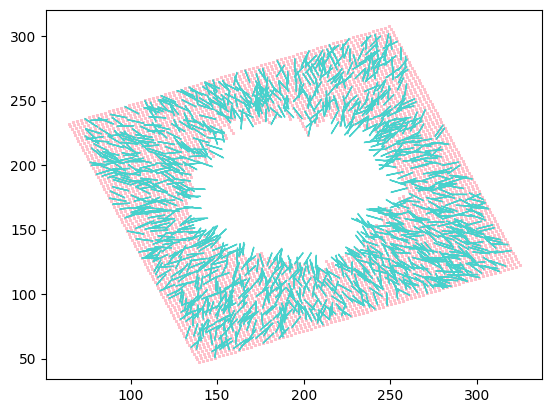

In [11]:
plotter.plot_train_data(train_data)

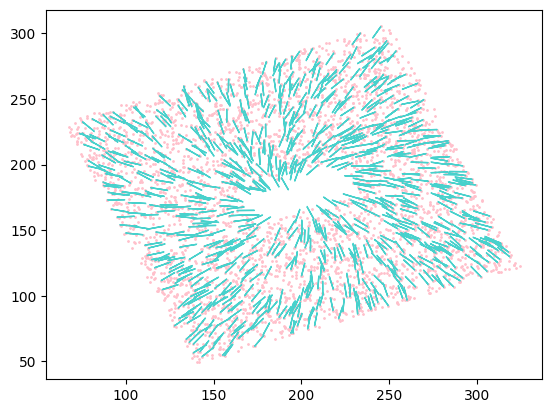

In [12]:
plotter.plot_data(val_data)

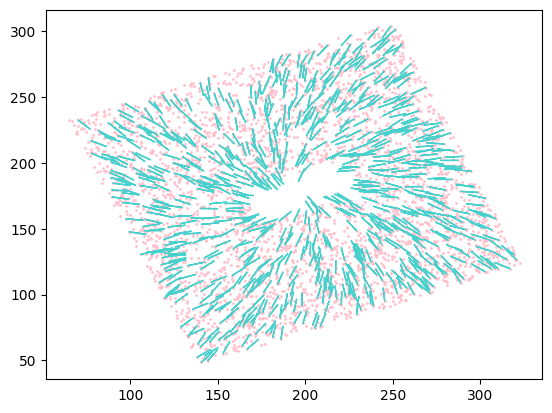

In [13]:
plotter.plot_data(test_data)

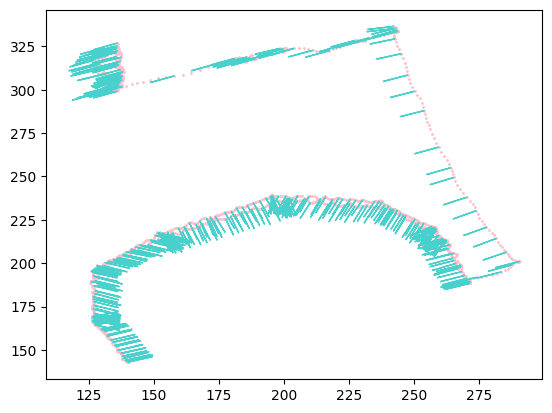

In [14]:
plotter.plot_data(real_data)

In [15]:
q_pose = real_data.poses[700]

q_x, q_y, q_Y_deg = q_pose
q_pose = np.array([q_x, q_y, (90+q_Y_deg)%360])

gt_pose_idx = train_data.gtquery(q_x, q_y, q_Y_deg)

Validation before filtering: 4000


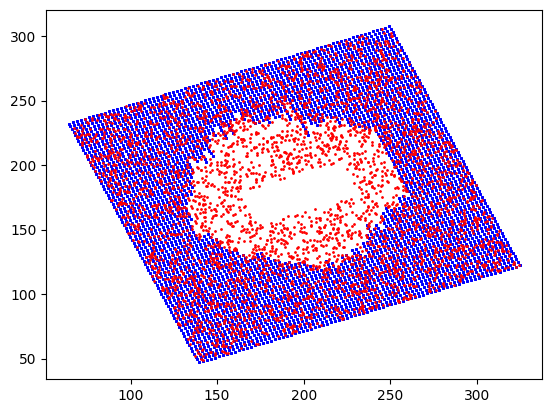

In [16]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation before filtering: " + str(len(val_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:01<00:00, 2011.25it/s]


Validation after filtering: 3253


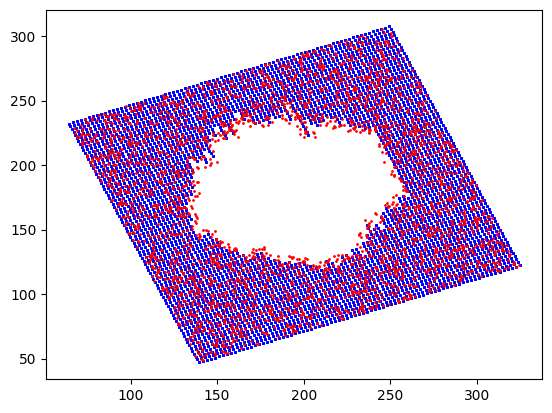

In [17]:
visualizer.filter_data(train_data, val_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(val_data, "red")

print("Validation after filtering: " + str(len(val_data.imgs)))

Test before filtering: 4000


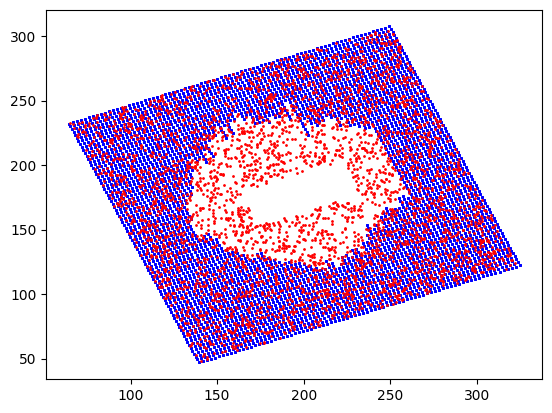

In [18]:
plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test before filtering: " + str(len(test_data.imgs)))

Filtering validation poses: 100%|█████████| 4000/4000 [00:01<00:00, 2128.26it/s]


Test after filtering: 3271


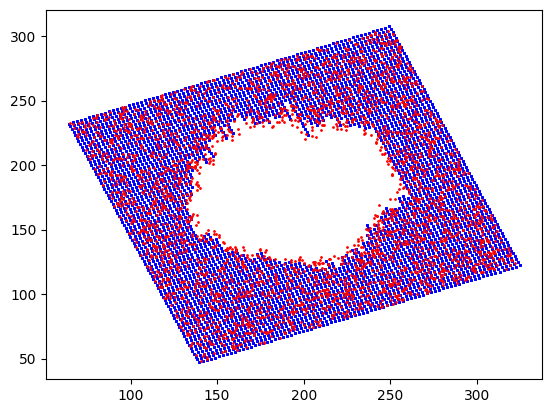

In [19]:
visualizer.filter_data(train_data, test_data)

plotter.plot_synth_poses_train(train_data, "blue")
plotter.plot_synth_poses_val(test_data, "red")

print("Test after filtering: " + str(len(test_data.imgs)))

iou: 0.9538183038020659
yaw difference tensor(3.7465) deg
localization error:  0.10107986 meters


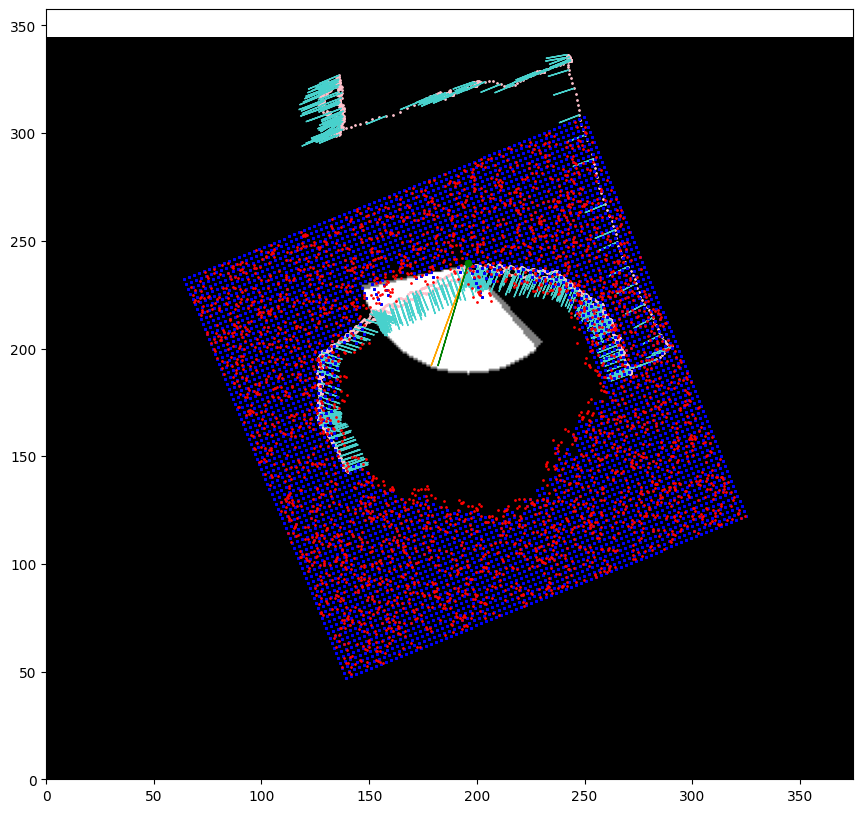

<Figure size 640x480 with 0 Axes>

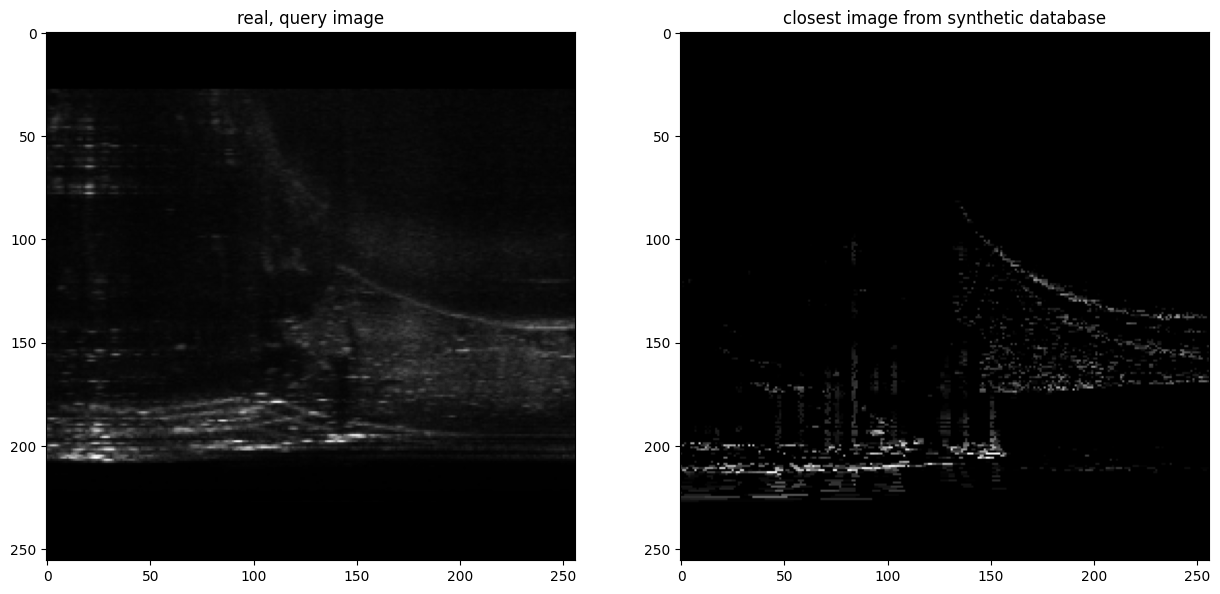

In [20]:
visualizer.localization(train_data, val_data, real_data)

In [21]:
print("Datasets before ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets before ground truth check
Training: 24005
Validation: 3253
Test: 3271


In [22]:
val_data = visualizer.check_gt(train_data, val_data)

In [23]:
test_data = visualizer.check_gt(train_data, test_data)

In [24]:
print("Datasets after ground truth check")
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Datasets after ground truth check
Training: 24005
Validation: 3251
Test: 3268


In [25]:
batch = 16
train_dataloader = DataLoader(train_data, batch_size=batch, shuffle=True)

## Model

### Model instantiation

In [26]:
model_name = "PVT"

In [27]:
net = PVT.Model().cuda()
net.train()

optimizer = torch.optim.AdamW(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.8)

drop = torch.nn.Dropout(0.3).cuda()

In [28]:
locacriterion = torch.nn.CrossEntropyLoss().cuda()
recocriterion = torch.nn.MSELoss().cuda()

In [29]:
total_params = metrics.count_parameters(net)
print("Total parameters: ", total_params)

Total parameters:  20571337


## Training Pipeline

### Train epochs

In [27]:
trainer = Trainer(writer, train_data, train_dataloader, val_data, net, optimizer, scheduler, drop, recocriterion, locacriterion)
num_epochs = 12

start_train = time.time()
best_model_path = trainer.train(num_epochs)
end_train = time.time()

training_time = end_train - start_train
print("Training time: ", training_time, "seconds")

epoch: 1


  0%|                                                  | 0/1501 [00:00<?, ?it/s]


TypeError: Model.forward() got an unexpected keyword argument 'reco'

In [ ]:
inference_time_per_image = metrics.inference_time(net, train_dataloader)
print("Inference time per image: ", inference_time_per_image, "seconds")

In [ ]:
metrics.get_descriptors(train_data, val_data, net)

## Visualize Training results on Test data

### Load the checkpoint model

In [30]:
#checkpoint_path = best_model_path
#print("Best model path: ", best_model_path)
checkpoint_path = "epoch_06.pth"
net = PVT.Model()
states.load_state(net, checkpoint_path)
net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [31]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

computing dataset descriptors


100%|█████████████████████████████████████| 24005/24005 [04:21<00:00, 91.95it/s]

descriptors computed!


### Visualize query results: sonar images

In [32]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

torch.Size([1, 16, 64, 64]) tensor(-3.6363, device='cuda:0', grad_fn=<MinBackward1>) tensor(3.9362, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 32, 32, 32]) tensor(-2.5183, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.8130, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 64, 16, 16]) tensor(-4.4751, device='cuda:0', grad_fn=<MinBackward1>) tensor(6.5143, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 128, 8, 8]) tensor(-3.4911, device='cuda:0', grad_fn=<MinBackward1>) tensor(6.0815, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.6781, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.3557, device='cuda:0', grad_fn=<MaxBackward1>)


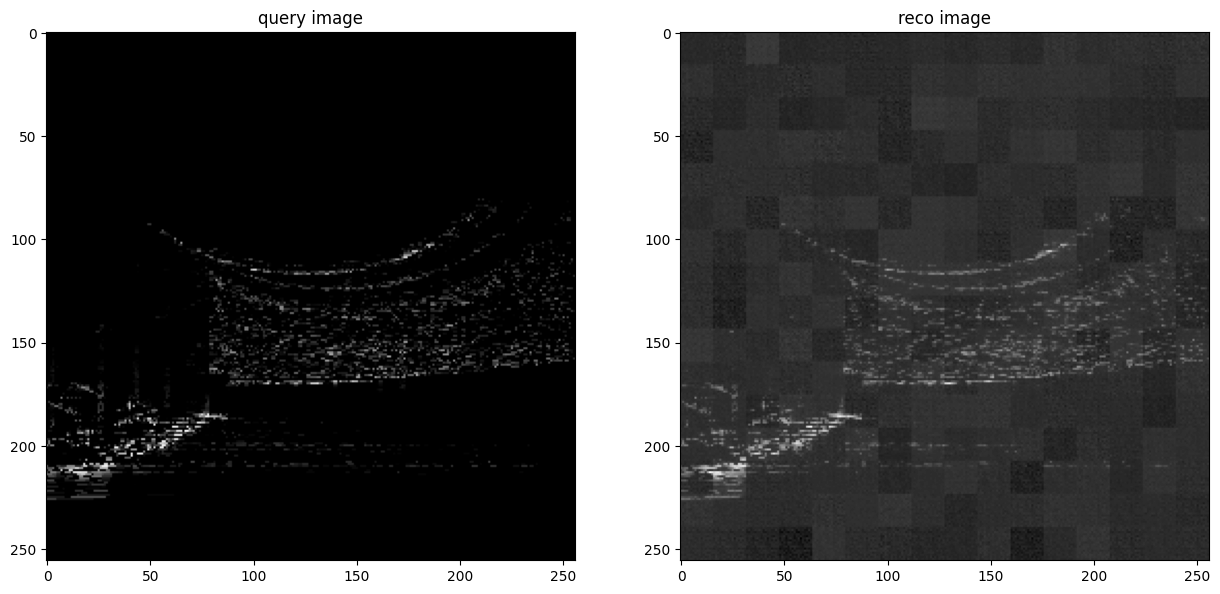

In [33]:
visualizer.analyze_feature_robustness(train_data, net)

iou: 0.904203250319936
localization error: 0.5590 meters
orientation error : 3.8280 degrees


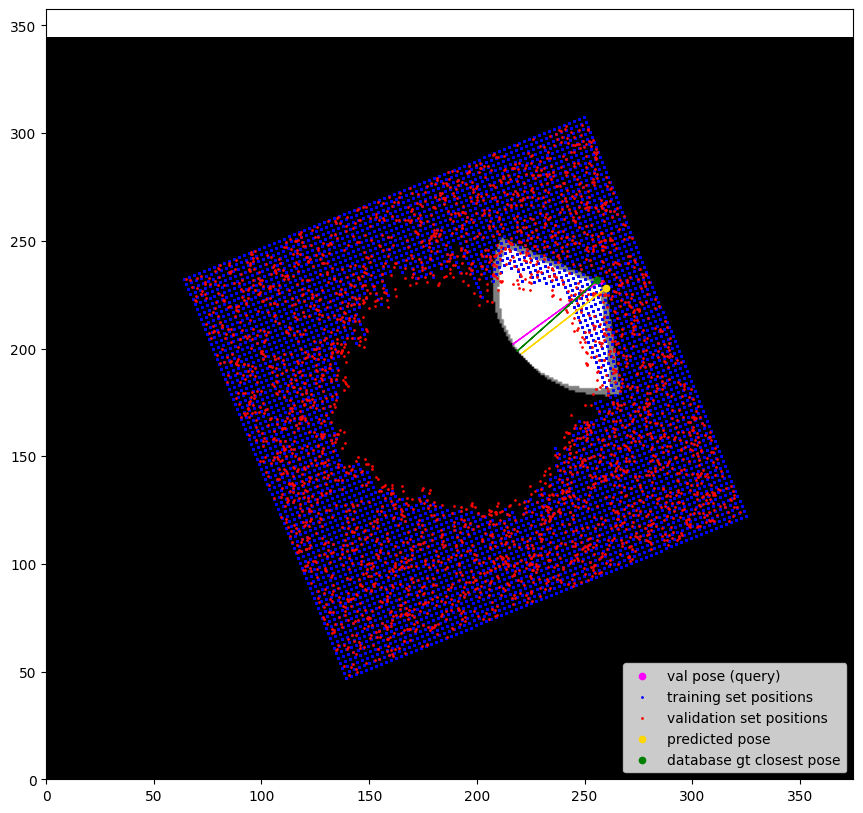

<Figure size 640x480 with 0 Axes>

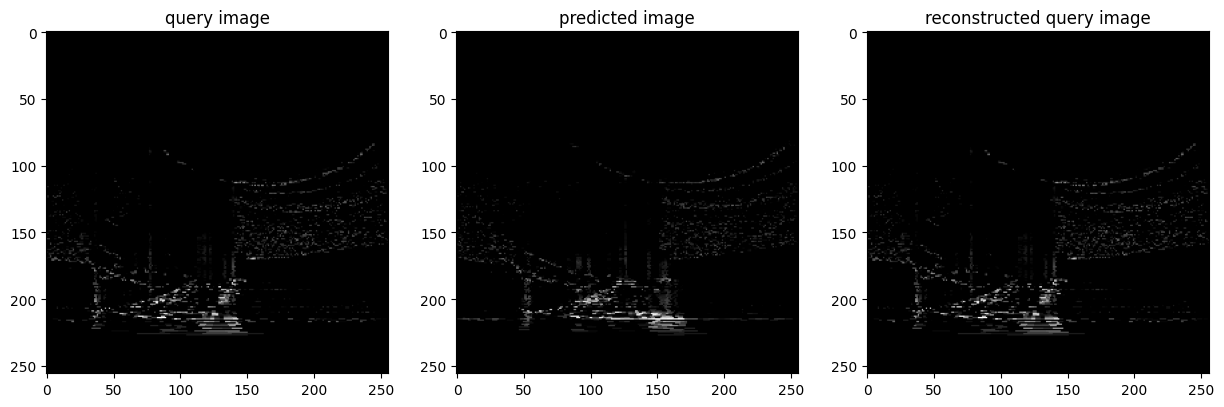

In [76]:
query_idx = random.randint(0, len(test_data))

loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [53]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(test_data))):
    loca_error, orie_error = visualizer.process(query_idx, net, train_data, test_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_t = avg_loca_error
aoe_t = avg_orie_error

  1%|▏                                        | 18/3268 [00:02<06:42,  8.07it/s]


KeyboardInterrupt: 

In [36]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [37]:
loca_errors.argmax()

np.int64(1097)

In [38]:
le = loca_errors[loca_errors<10]
oe = orie_errors[orie_errors<10]
print(le.mean())
print(oe.mean())

1.1192659
3.6517198


## Process real images

query_idx: 182
201.53015 237.94006 2.3475506 -45.495255
iou: 0.0
localization error Upper:  12.770588 meters


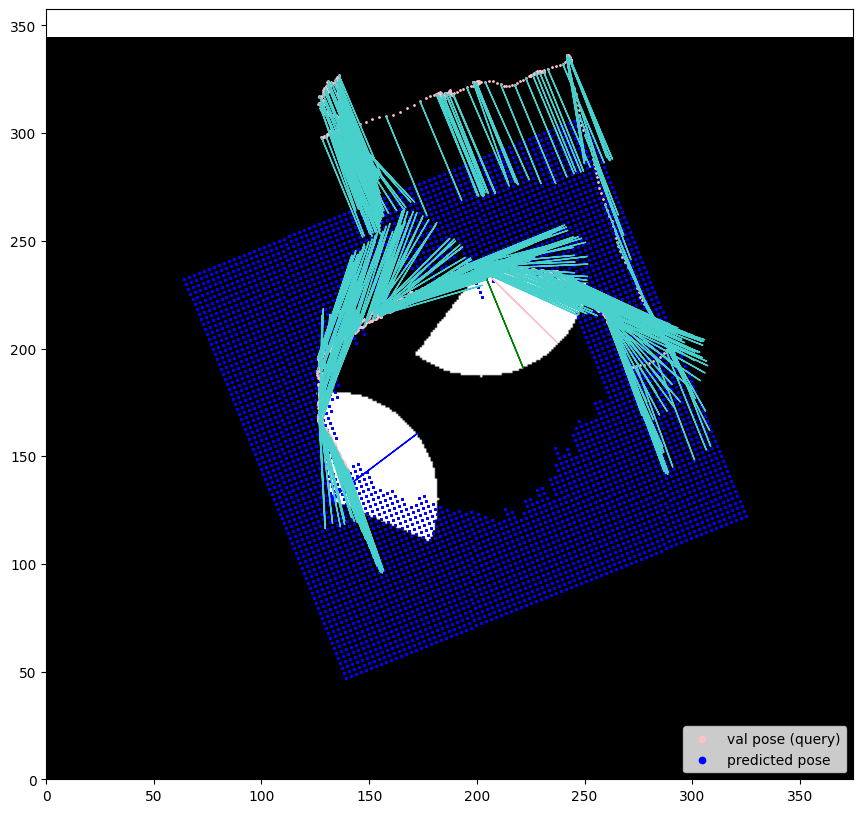

<Figure size 640x480 with 0 Axes>

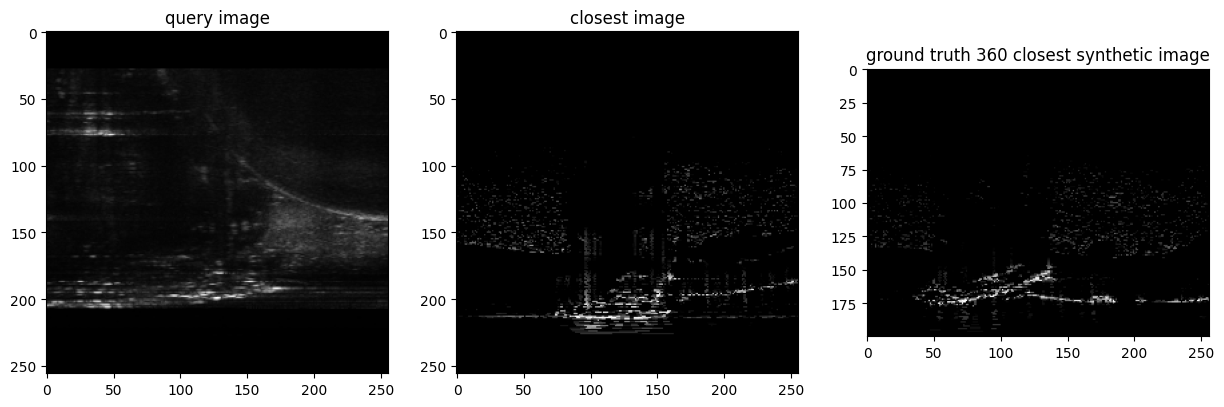

In [39]:
query_idx = random.randint(0, 600)
train_data.apply_random_rot = True
train_data.training = True
print("query_idx:", query_idx)
visualizer.process_real(query_idx, net, train_data, real_data)

## Process ONLY real images

In [40]:
real_data_train = load_only_real_datasets.SonarDescriptorOnlyRealDataset()
real_data_valid = load_only_real_datasets.SonarDescriptorOnlyRealDataset(real_data_train)

In [41]:
real_data_train.computeDescriptors(net)

computing dataset descriptors


100%|█████████████████████████████████████████| 710/710 [00:08<00:00, 86.19it/s]

descriptors computed!


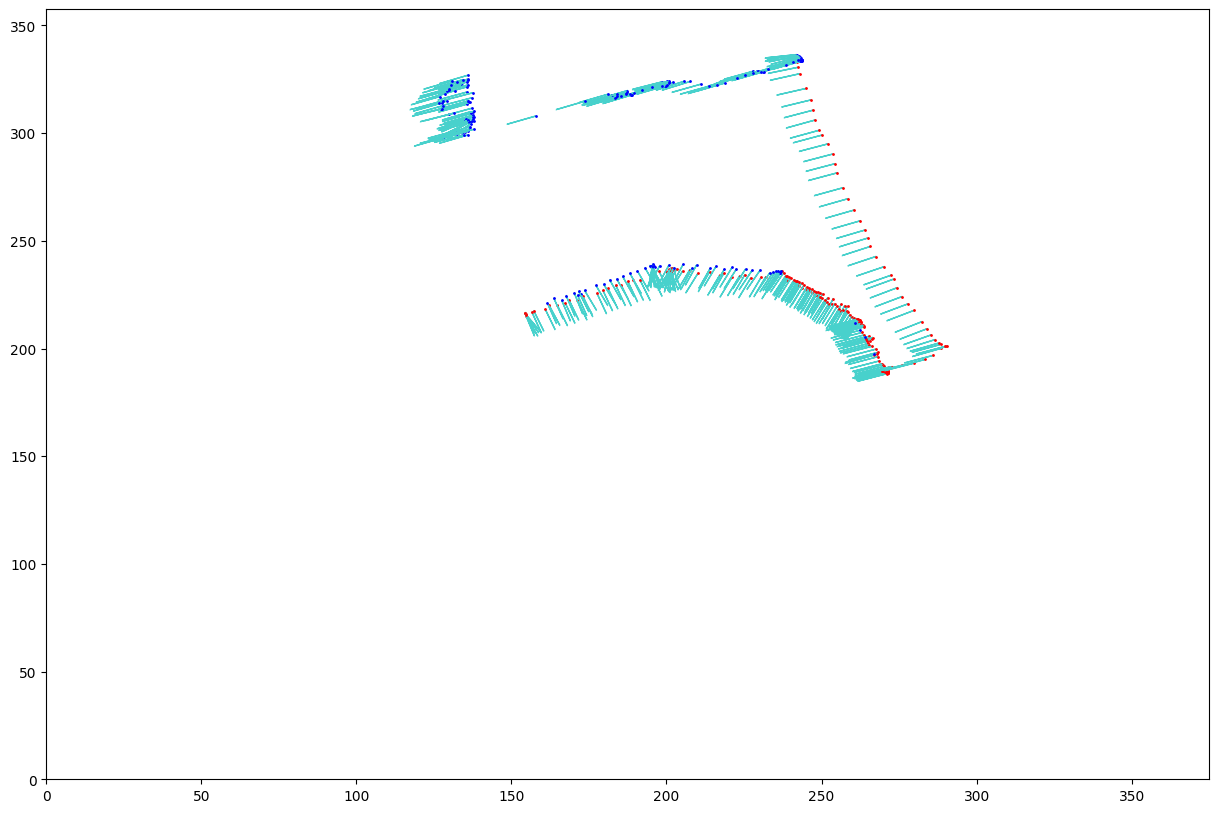

In [42]:
visualizer.visualize_real(train_data, real_data)

iou: 0.21024414944455394
localization error: 5.7977 meters
orientation error : 41.2014 degrees


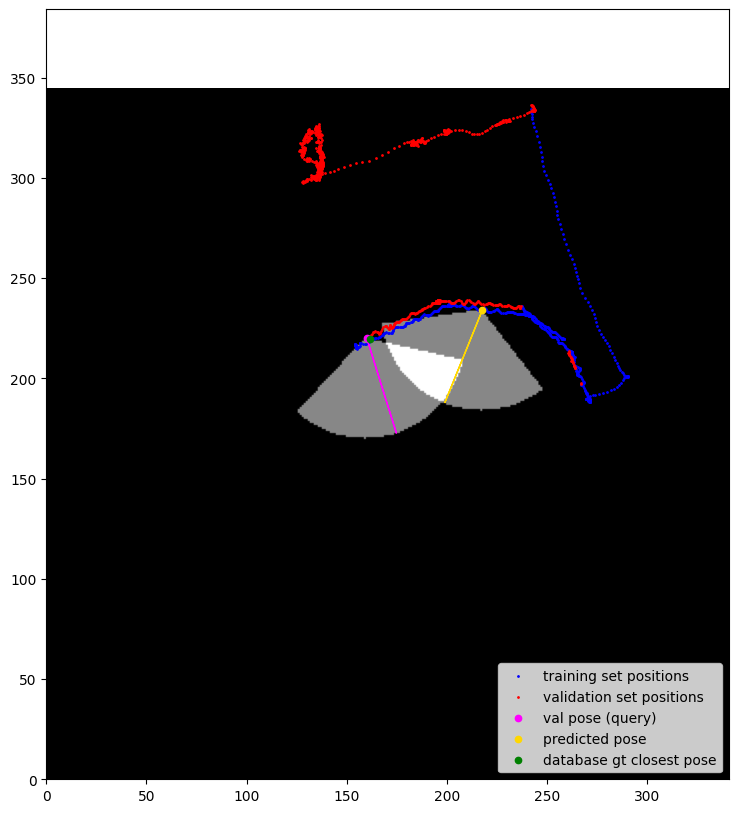

<Figure size 640x480 with 0 Axes>

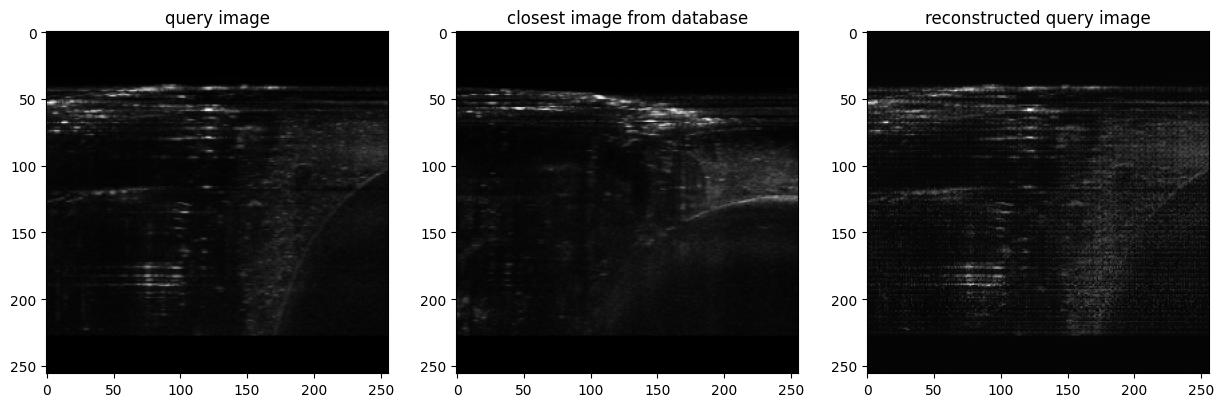

In [43]:
query_idx = random.randint(700, len(real_data_valid))
loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [44]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(real_data_valid))):
    loca_error, orie_error = visualizer.process_only_real(query_idx, net, real_data_train, real_data_valid, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.abs(np.array(orie_errors)).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

ale_r = avg_loca_error
aoe_r = avg_orie_error

100%|█████████████████████████████████████████| 785/785 [00:20<00:00, 38.02it/s]

average localization error: 6.0305 meters
average orientation error : 32.6405 degrees


In [45]:
avg_orie_error.min()

np.float32(32.64053)

## Results

In [46]:
file_path = "results.csv"
metrics.save_results(model_name, total_params, training_time, inference_time_per_image, ale_t, aoe_t, ale_r, aoe_r, file_path)

print(f"Model name: {model_name}")
print(f"Total parameters: {total_params}")
print(f"Training time: {training_time:6.4f} seconds")
print(f"Inference time per image: {inference_time_per_image:6.4f} seconds")
print(f"Average localization error in Test: {ale_t:6.4f} meters")
print(f"Average orientation error in Test: {aoe_t:6.4f} degrees")
print(f"Average localization error in Real: {ale_r:6.4f} meters")
print(f"Average orientation error in Real: {aoe_r:6.4f} degrees")

NameError: name 'training_time' is not defined